In [1]:
from link_bot_notebooks import notebook_finder
from link_bot_notebooks import toy_problem_optimization_common as tpo
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

importing Jupyter notebook from /home/pmitrano/catkin_ws/src/link_bot/link_bot_notebooks/src/link_bot_notebooks/toy_problem_optimization_common.ipynb


In [2]:
g = np.array([[4], [0], [5], [0], [6], [0]])
dt = 0.1

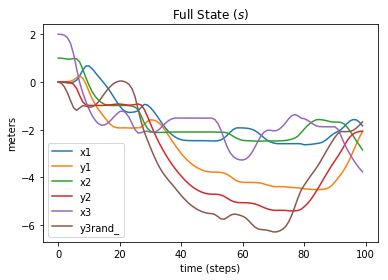

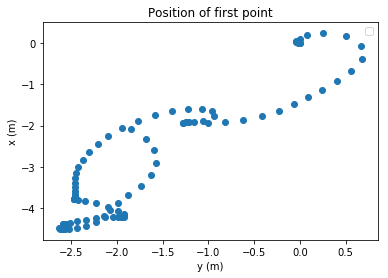

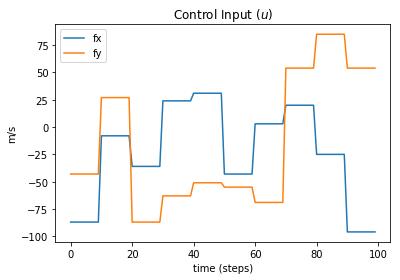

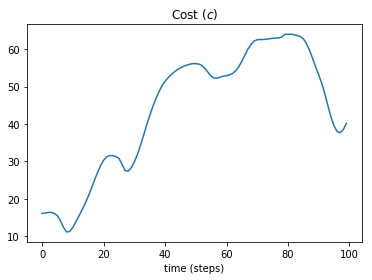

In [3]:
data = tpo.load_data("/home/pmitrano/catkin_ws/src/link_bot/link_bot_teleop/data/rand_forces_1.txt", g, extract_func=tpo.two_link_pos_extractor)
tpo.plot_gz_data_v2(plt, data[:100])

# Random Params

In [4]:
N = 100
costs = np.zeros(N)
rand_model = tpo.LinearStateSpaceModelWithQuadraticCost(N=6, M=2, L=2)
for i in range(N):
    random_params = np.random.randn(rand_model.size())
    rand_model.from_params(random_params)
    costs[i] = tpo.state_prediction_objective(rand_model, g, data, dt)
print("Median cost for random parameters {:.3f}".format(np.median(costs)))

Median cost for random parameters 217724.451


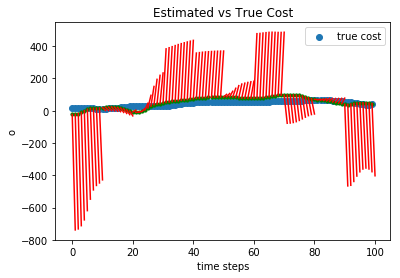

In [5]:
tpo.plot_cost(plt, rand_model, data[0:100], dt, g)

In [6]:
tpo.mean_dot_product(rand_model, data, dt, g)

-511.15743601309833

# Train

In [4]:
q = raw_input("ARE YOU SURE YOU WANT TO RUN THIS?")
np.random.seed(123)
model = tpo.LinearStateSpaceModelWithQuadraticCost(N=6, M=2, L=2)
if q == 'y':
    start = datetime.now()
    print("Training Starting at: {}".format(start))
    result = tpo.train(data, model, g, dt, tpo.cost_prediction_objective, tol=0.1, method='CG', options={'maxiter': 15000})
    end = datetime.now()
    print("Training Starting at: {}".format(end))
    train_time_s = (end - start).total_seconds()
    print("training time (seconds) {}".format(train_time_s))
else:
    model.load("./rand_forces_model_1.npz")

ARE YOU SURE YOU WANT TO RUN THIS?n


In [5]:
tpo.eval_model(model, data, g, dt);

Loss Components:
	current cost: 0.530238379818
	predict next latent state: 0.462902922407
	predict next cost: 11.0506024376
	regularization: 5.02454225799e-05
Complete Losses:
	predict next latent state and current cost: 0.496620896535
	predict next cost and current cost: 5.79047065412

Model reduction Matrix: [[ 2.31  2.07  0.12  0.03 -0.05  0.11]
 [-1.17  3.72 -0.07 -0.24 -0.07  0.46]]
 Dynamics matrices: [[-0.    0.01]], [[ 0.    0.01]
 [-0.05  0.02]]
 Cost Matrix: [[ 0.11 -0.21]
 [ 0.14  0.07]]


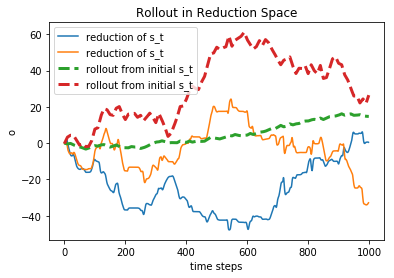

In [6]:
tpo.plot_o_rollout(plt, model, data, dt, g)

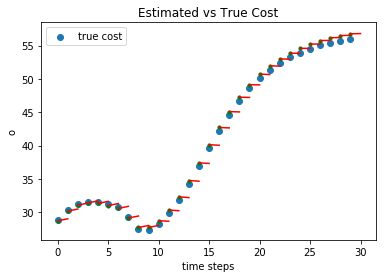

In [7]:
tpo.plot_cost(plt, model, data[20:50], dt, g)

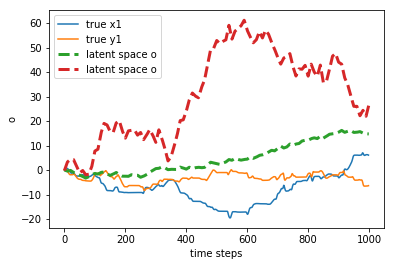

In [8]:
tpo.plot_xy_rollout(plt, model, data, dt, data[0][0], g);

4.827030585911015e-05


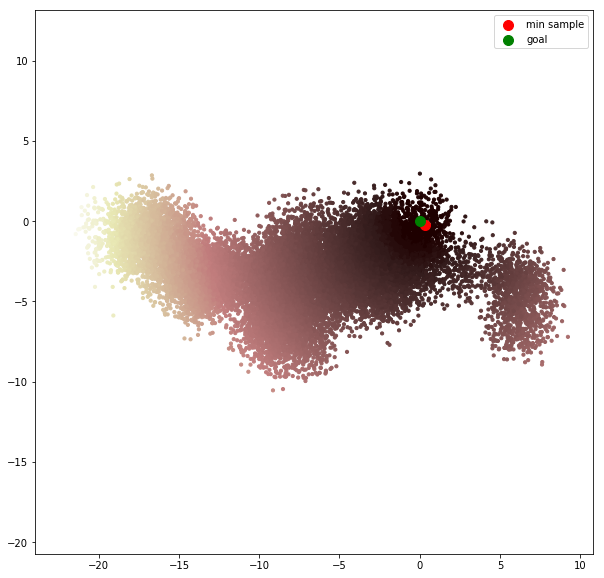

In [9]:
gx = 0
gy = 0
goal = np.array([[gx], [gy], [gx+1], [gy], [gx+2], [gy]])
min_sample, min_cost = tpo.plot_costmap(plt, model, data, goal, samples=20, spread=1)
print(min_cost)
plt.scatter([min_sample[0]], [min_sample[1]], s=100, c='Red', label='min sample');
plt.scatter([gx], [gy], s=100, c='Green', label='goal');
plt.legend();

(array([[0.],
        [0.],
        [1.],
        [0.],
        [2.],
        [0.]]), 0.0)

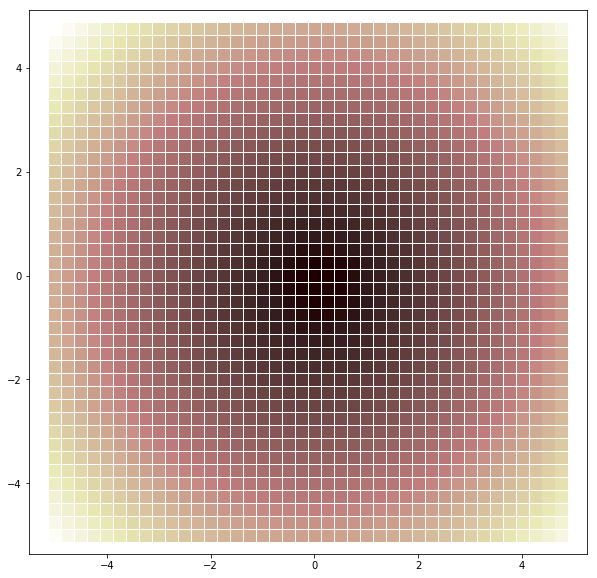

In [13]:
tpo.plot_costmap_2(plt, model, data, goal, resolution=0.25, minimum=-5, maximum=5)

In [34]:
print("Mean dot product of predicted change in cost with true change in cost (over one step): ")
print(tpo.mean_dot_product(model, data, dt, g))

Mean dot product of predicted change in cost with true change in cost (over one step): 
1.6382934783597451


In [35]:
s = np.array([[0],[0],[1],[0],[2],[0]])
action = np.array([[80],[-100]])
s_back = np.linalg.lstsq(model.A, model.reduce(s), rcond=None)[0]
print("reproducing the input state")
print(s_back)
print("predicting the next state in o-space, then reproducing that")
s_back_next = np.linalg.lstsq(model.A, model.predict_from_s(s, action, 1), rcond=None)[0]
print(s_back_next)

reproducing the input state
[[ 0.04]
 [-0.04]
 [ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [-0.01]]
predicting the next state in o-space, then reproducing that
[[ 0.9 ]
 [-1.46]
 [ 0.05]
 [ 0.12]
 [ 0.02]
 [-0.2 ]]


In [27]:
o0 = np.array([[4.463559], [0.958733]])
a0 = np.array([[-90], [-100]])
o1 = model.predict_from_o(o0, a0, dt)
print(o1)
a1 = np.array([[10], [-100]])
o2 = model.predict_from_o(o1, a1, dt)
print(o2)

[[ 26.16]
 [-30.05]]
[[ 38.85]
 [-41.77]]
